# Multi Agent Deep Deterministic Policy Gradients (MADDPG)
---
In this notebook, we train DDPG with OpenAI Gym's Pendulum-v0 environment.

### 1. Import the Necessary Packages

In [2]:
from unityagents import UnityEnvironment

import numpy as np
from collections import deque

import torch

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

In [3]:
# environment configuration
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# environment information
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like: ', states[0])

Number of agents: 2
Number of actions: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [8]:
env.close()

### 3. Train the Agent with DDPG

In [ ]:
# env_info = env.reset(train_mode=True)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break

In [5]:
#import importlib
from ddpg_agent import Agent
from ddpg_agent import ReplayBuffer
from ddpg_agent import Academy
from ddpg_agent import OUNoise

shared_replay_memory = ReplayBuffer(action_size, 2)
# unchecked shared OUNoise
noise = OUNoise(action_size, 2)

# initialise an agent
agent1 = Agent(identity=1, state_size=24, action_size=2, random_seed=2, memory=shared_replay_memory, noise=noise)
agent2 = Agent(identity=2, state_size=24, action_size=2, random_seed=2, memory=shared_replay_memory, noise=noise)
               
# initialise an academy
academy = Academy(state_size=24, action_size=2, random_seed=2, memory=shared_replay_memory)


Episode 508	 Score: 1.20	 Average Score: 0.50	Max Score: 2.60

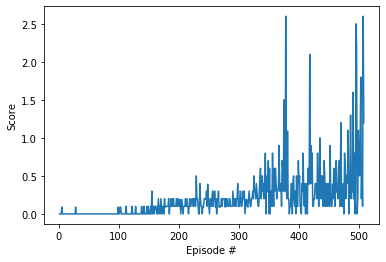

In [6]:
#importlib.reload(ddpg_agent)
def ddpg(n_episodes=5000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    #scores_list = []
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations            # get the current state
        score = np.zeros(n_agents)                          # initialize the score (for each agent)
        
        agent1.reset()
        agent2.reset()
        
        while True:
            actions1 = agent1.act(states[0], True)
            actions2 = agent2.act(states[1], True)
            actions = np.concatenate( (actions1, actions2) )
            

            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations      # get the next state
            rewards = env_info.rewards                      # get the reward        
            dones = env_info.local_done                     # see if episode has finished 
                        
            # agent 1
            next_states1 = env_info.vector_observations[0]   # get the next state
            rewards1 = env_info.rewards[0]                   # get the reward
            dones1 = env_info.local_done[0]                  # see if episode has finished
            agent1.step(states[0], actions1, rewards1, next_states1, dones1)
            
            # agent 2
            next_states2 = env_info.vector_observations[1]   # get the next state
            rewards2 = env_info.rewards[1]                   # get the reward
            dones2 = env_info.local_done[1]                  # see if episode has finished
            agent2.step(states[1], actions2, rewards2, next_states2, dones2)
            
            academy.step(agent1, shared_replay_memory)
            academy.step(agent2, shared_replay_memory)
            
            states = next_states
            
            score += env_info.rewards #rewards
            if np.any(env_info.local_done):  #dones
                break
                
        scores.append(np.max(score))
        scores_deque.append(np.max(score))
        
        print('\rEpisode {}\t Score: {:.2f}\t Average Score: {:.2f}\tMax Score: {:.2f}'.format(i_episode, np.max(score), np.mean(scores_deque), np.max(scores)), end="")

        if np.mean(scores_deque) >= 0.5:
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_agent_1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_agent_2.pth')
            torch.save(academy.critic_local.state_dict(), 'checkpoint_academy.pth')
            break
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In [5]:
# test the trained agents
for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]           # reset the environment
    states = env_info.vector_observations                        # get initial states
    score = np.zeros(n_agents)
    
    while True:
        actions1 = agent1.act(states[0],False)
        actions2 = agent2.act(states[1],False)
        actions = np.concatenate((actions1, actions2))
        
        env_info = env.step( actions )[brain_name]               # send the action to the environment                            
        next_states = env_info.vector_observations               # get the next state        
        rewards = env_info.rewards                               # get the reward        
        dones = env_info.local_done                              # see if episode has finished        
        
        score += rewards

        states = next_states

        if np.any(dones):                              
            break

    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.max(score)))  

Episode: 	0 	Score: 	2.60
Episode: 	1 	Score: 	2.70
Episode: 	2 	Score: 	2.60


### 6. Explore

In this exercise, we have provided a sample DDPG agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster than this benchmark implementation.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task!
- Write your own DDPG implementation.  Use this code as reference only when needed -- try as much as you can to write your own algorithm from scratch.
- You may also like to implement prioritized experience replay, to see if it speeds learning.  
- The current implementation adds Ornsetein-Uhlenbeck noise to the action space.  However, it has [been shown](https://blog.openai.com/better-exploration-with-parameter-noise/) that adding noise to the parameters of the neural network policy can improve performance.  Make this change to the code, to verify it for yourself!
- Write a blog post explaining the intuition behind the DDPG algorithm and demonstrating how to use it to solve an RL environment of your choosing.  